In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
if not "/home/jeon/jeonpkg" in sys.path:
    sys.path.append("/home/jeon/jeonpkg")
    print("/home/jeon/jeonpkg update")
from importlib import reload
import jeon as jn
import jfiles as jf
import jplots as jp
from rur import uri, uhmi, painter, drawer

import os
# from rur import uri, uhmi, painter
import time
from matplotlib.ticker import MultipleLocator
import gc
gc.collect()

/home/jeon/jeonpkg update
Module JEON(220503.0) loading success
Module JFIELS(210126.0) loading success
Module JEON(220503.0) loading success
Module JFIELS(210126.0) loading success
Module JPLOTS(220503.0) loading success


0

In [2]:
modes = ['y07206', 'y36415', 'y36413', 'y10002']
mode = modes[0]
nout, nstep, zred, aexp, gyr = jn.pklload(f'/storage6/jeon/data/{mode}/{mode}_nout_nstep_zred_aexp_gyr.pickle')
repo = f'/storage3/Clusters/{mode[1:]}'
# TreeMaker
tm = jn.pklload(f"/storage6/jeon/data/{mode}/tm/{mode}_TreeMaker.pickle")
galtm = jn.treemaker(galaxy=True, tm=tm, mode=mode)
tm = None

# GalaxyMaker
mem=jn.memory_usage()
gmpids = {}
for i, iout in enumerate(nout):
    snap = uri.RamsesSnapshot(repo, iout, path_in_repo='snapshots', mode='yzics')
    gm, gmpid = uhmi.HaloMaker.load(snap, galaxy=True, load_parts=True)
    if i==0:
        print(len(gm))
    cumparts = np.insert(np.cumsum(gm["nparts"]), 0, 0)
    inst = np.copy(gmpid)
    gmpid = [inst[ cumparts[j]:cumparts[j+1] ] for j in range(len(gm))]
    gmpids[iout] = np.copy(gmpid)
    snap.clear()

path = "./youngtree/"
file_list = os.listdir(path)
file_list = [file for file in file_list if (file.startswith(f"YT_{mode}") & file.endswith(".pickle"))]

Tree building...
Tree building done (0.09 sec)
[debug] memory usage:  276.86328 MB
248


/home/jeon/.conda/envs/jeonpy/lib/python3.9/site-packages/numpy/lib/function_base.py:804: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


In [11]:
def return_fat(target, usefat2=False):
    fat = target['fat1']
    if fat > 0:
        return fat
    if usefat2:
        fat = target['fat2']
        if fat > 0:
            return fat
        else:
            return None

def return_branch(target, tm=None, usefat2=False):
    istep = target['timestep']
    leng = istep - np.min( list(tm.dat.keys()) )
    fat = return_fat(target, usefat2=usefat2)
    if fat is None:
        # print(f"broken at step={istep}")
        return np.atleast_1d(target)
    branch = target
    for i in range(leng):
        igal = tm.loadgals(istep-1-i, fat)
        branch = np.hstack((branch, igal))
        fat = return_fat(igal, usefat2=usefat2)
        if fat is None:
            # if istep-i-1 > 1:
                # print(f"broken at step={istep-i-1}")
            return branch
    return branch

YoungTree
168
(218, 168, 2, 3, 3, 0, 219, 3, 220, 0, 3, -1, -1, 0, -1, -1, -1, -1, -1, 1.0000004, 13.758523, 4.1915249e+09, 0., 0.2186538, 0.40214023, 0.50347567, 538.4431, 16.06894, -364.29028, -0.00275882, -0.00091808, -0.00014939, 0.0001323, 0.00548521, 0.00611616, 0.00699949, 362.4088, -36.59839, 325.81042, 0.3396925, 97.11902, 1.3507521, 1.3507521, 0., 0., 0.00011882, 4.1915249e+09, 19172.66, 23.10968, 86.71642, 0.00011882) <class 'numpy.record'> 9.622372

OldTree
168
(218, 168, 2, 3, 3, 0, 219, 3, 220, 0, 3, -1, -1, 0, -1, -1, -1, -1, -1, 1.0000004, 13.758523, 4.1915249e+09, 0., 0.2186538, 0.40214023, 0.50347567, 538.4431, 16.06894, -364.29028, -0.00275882, -0.00091808, -0.00014939, 0.0001323, 0.00548521, 0.00611616, 0.00699949, 362.4088, -36.59839, 325.81042, 0.3396925, 97.11902, 1.3507521, 1.3507521, 0., 0., 0.00011882, 4.1915249e+09, 19172.66, 23.10968, 86.71642, 0.00011882) <class 'numpy.record'>

TreeMaker
158
(218, 168, 2, 3, 3, 0, 219, 3, 220, 0, 3, -1, -1, 0, -1, -1, -1, 

(-0.01, 1.01)

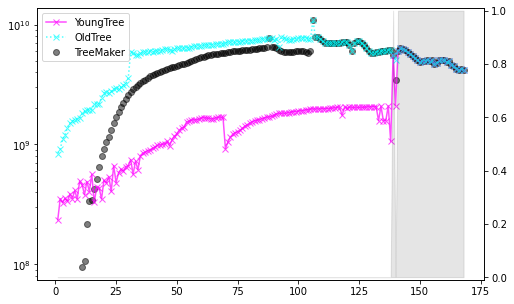

In [37]:
file = file_list[np.random.randint(0, len(file_list)-1)]
# file = file_list[np.random.randint(0, 3-1)]
young_tree = np.atleast_1d(jn.pklload(path+file))
print("YoungTree")
print(len(young_tree))
target = young_tree[0]
print(target, type(target), np.log10(target['m']))


old_tree = np.atleast_1d(jn.find_fixtree(target, nsteps=4, tm=galtm, return_fat1=False, gmpids=gmpids))
print("\nOldTree")
print(len(old_tree))
print(old_tree[0], type(old_tree[0]))

treemaker = np.atleast_1d(return_branch(target, tm=galtm, usefat2=True))
print("\nTreeMaker")
print(len(treemaker))
print(treemaker[0], type(treemaker[0]))



leng = min(len(old_tree), len(young_tree))
x = young_tree['timestep'][:leng]
match = (young_tree['id'][:leng] - old_tree['id'][:leng]) == 0


fig, ax = plt.subplots(figsize=(8,5))

# print(young_tree['timestep'])
# arg = young_tree['m'] < 0.9*young_tree['m'][0]
# print(arg)
# arg = np.where(arg)[0]
# print(arg)
# maxt = np.max(young_tree['timestep'][arg])


ax.plot(young_tree['timestep'], young_tree['m'], color='magenta', label='YoungTree', marker='x', alpha=0.7)
ax.plot(old_tree['timestep'], old_tree['m'], color='cyan', ls=':', label='OldTree', marker='x', alpha=0.7)
ax.scatter(treemaker['timestep'], treemaker['m'], color='black' , label='TreeMaker', marker='o', alpha=0.5)
ax.set_yscale("log")
# ax.axvline(maxt)
# arg = old_tree['m'] < 0.9*old_tree[0]['m']
# arg = np.where(arg)[0]
# maxt = np.max(old_tree['timestep'][arg])
# ax.axvline(maxt, color='red', ls=":")
ax.legend()

ax2 = ax.twinx()
ax2.fill_between(x,np.zeros(len(x)),match, color='black', alpha=0.1)
ax2.set_ylim(-0.01, 1.01)


In [ ]:
# fig, ax = plt.subplots(figsize=(7,7))
# jp.draw_totalmap(target, ax, snap_now,radii=5, modes=['star', 'gas'], gmpid=gmpids[iout], info=True, simmode=mode, galaxy=True, gasweak=False, resolution=320)